In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from transformers import  TFTrainingArguments
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

In [ ]:
!unzip '/content/data_augmentation.zip'


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data_augmentation/FACE/1144.jpg_aug_169.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_17.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_18.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_19.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_2.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_20.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_21.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_22.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_23.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_24.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_25.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_26.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_27.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_28.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_29.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_3.j

In [ ]:
base_path ='/content/data_augmentation'

In [ ]:

def split_data(data_dir):
    datagen_kwargs = dict(rescale=1./255, validation_split=.20)
    dataflow_kwargs = dict(target_size=(224, 224), batch_size=32)


    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

    train_generator = train_datagen.flow_from_directory(
      data_dir, subset="training", shuffle=True, class_mode='sparse', **dataflow_kwargs)
    valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
    valid_generator = valid_datagen.flow_from_directory(
        data_dir, subset="validation", shuffle=True, class_mode='sparse', **dataflow_kwargs)

    return train_generator, valid_generator
train_generator,valid_generator = split_data(base_path)

Found 8690 images belonging to 49 classes.
Found 1720 images belonging to 49 classes.


In [ ]:
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
classifier_model = inception_v3
IMAGE_SHAPE = (224, 224)


In [ ]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  base_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  base_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 8690 files belonging to 49 classes.
Using 6952 files for training.
Found 8690 files belonging to 49 classes.
Using 1738 files for validation.


In [ ]:
import numpy as np

class_names = np.array(train_ds.class_names)
print(class_names)

['1.5_1_CAMELIA._5_ALLURES' '1932_COLLECTION_(2022)' 'BATH_AND_BODY'
 'BELTS' 'BLUE_LIGHT_GLASSES' 'BODY' 'BOY_DE_CHANEL' 'BRACELETS'
 'BROOCHES' 'BRUSHES_AND_ACCESSORIES' 'CAMELLIAS'
 'CLEANSERS___MAKEUP_REMOVERS' 'COCO_CRUSH' 'COMETE' 'COSTUME_JEWELRY'
 'EARRINGS' 'EXCEPTIONAL_PIECES' 'EYEGLASSES' 'EYES' 'EYE___LIP_CARE'
 'FACE' 'HANDBAGS' 'HEADWEAR' "L'ESPRIT_DU_LION"
 'LES_INTEMPORELS_DE_CHANEL' 'LIPS' 'MASKS___EXFOLIATORS'
 'MASSAGE_ACCESSORIES' 'MEN' 'MISTS' 'MOISTURIZERS' 'NAILS' 'NECKLACES'
 'N_5' 'N_5_COLLECTION' 'OILS' 'OTHER_ACCESSORIES' 'READY_TO_WEAR' 'RINGS'
 'SCARVES' 'SERUMS' 'SETS' 'SHOES' 'SMALL_LEATHER_GOODS'
 'SOUS_LE_SIGNE_DU_LION_HJ' 'SUNGLASSES' 'TONERS___LOTIONS' 'WATCHES'
 'WOMEN']


In [ ]:
# class_names = np.array(train_generator.class_indices)
# print(class_names)
# # Convert DirectoryIterator to tf.data.Dataset
# def generator_to_dataset(generator):
#     return tf.data.Dataset.from_generator(
#         lambda: generator,
#         output_signature=(
#             tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
#             tf.TensorSpec(shape=(None,), dtype=tf.int32)  # Changed to (None,) and dtype to tf.int32
#         )
#     )
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([36, 32,  6,  4, 35, 25,  4, 26, 18, 35, 24, 42, 48, 19, 34,  5, 46,
       17, 19, 20,  2, 29, 33, 35, 12, 28, 47, 41, 34, 34, 11, 31],
      dtype=int32)>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

class MyHubKerasLayer(tf.keras.layers.Layer):
  def __init__(self, handle, trainable=False, **kwargs):
    super(MyHubKerasLayer, self).__init__(trainable=trainable, **kwargs)
    self.handle = handle

  def build(self, input_shape):
    self.hub_layer = hub.KerasLayer(self.handle, input_shape=input_shape)
    self.built = True

  def call(self, inputs):
    return self.hub_layer(inputs)

feature_extractor_layer = MyHubKerasLayer(
    classifier_model,
    input_shape=(224, 224, 3),
    trainable=False)

num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

<ipython-input-13-284fc75f658b>:8: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(MyHubKerasLayer, self).__init__(trainable=trainable, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ my_hub_keras_layer (MyHubKerasLayer) │ (None, 1001)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 49)                  │          49,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,098 (191.79 KB)

 Trainable params: 49,098 (191.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)

NUM_EPOCHS = 10
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    )

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=[early_stopping,tensorboard_callback])

Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 1131s 5s/step - acc: 0.7619 - loss: 1.2104 - val_acc: 0.9971 - val_loss: 0.0198
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 1039s 5s/step - acc: 0.9979 - loss: 0.0132 - val_acc: 0.9983 - val_loss: 0.0096
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 1044s 5s/step - acc: 1.0000 - loss: 0.0042 - val_acc: 0.9988 - val_loss: 0.0068
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 1152s 5s/step - acc: 1.0000 - loss: 0.0024 - val_acc: 0.9988 - val_loss: 0.0055
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 1040s 5s/step - acc: 1.0000 - loss: 0.0017 - val_acc: 0.9988 - val_loss: 0.0046
Epoch 6/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 1042s 5s/step - acc: 1.0000 - loss: 0.0012 - val_acc: 0.9994 - val_loss: 0.0040
Epoch 7/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 1100s 5s/step - acc: 1.0000 - loss: 9.4488e-04 - val_acc: 0.9994 - val_loss: 0.0036
Epoch 8/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 1098s 5s/step - acc: 1.0000 - loss: 7.4813e-04 - val_acc: 0.9994 - val_loss: 0.0033
Epoch 9/10
218/218 ━━━━━━━━━━━━━

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print("Prediction lables")
print(predicted_label_batch)
print("Actual label")
print(class_names[labels_batch])

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Prediction lables
['OTHER_ACCESSORIES' 'NECKLACES' 'BOY_DE_CHANEL' 'BLUE_LIGHT_GLASSES'
 'OILS' 'LIPS' 'BLUE_LIGHT_GLASSES' 'MASKS___EXFOLIATORS' 'EYES' 'OILS'
 'LES_INTEMPORELS_DE_CHANEL' 'SHOES' 'WOMEN' 'EYE___LIP_CARE'
 'N_5_COLLECTION' 'BODY' 'TONERS___LOTIONS' 'EYEGLASSES' 'EYE___LIP_CARE'
 'FACE' 'BATH_AND_BODY' 'MISTS' 'N_5' 'OILS' 'COCO_CRUSH' 'MEN' 'WATCHES'
 'SETS' 'N_5_COLLECTION' 'N_5_COLLECTION' 'CLEANSERS___MAKEUP_REMOVERS'
 'NAILS']
Actual label
['OTHER_ACCESSORIES' 'NECKLACES' 'BOY_DE_CHANEL' 'BLUE_LIGHT_GLASSES'
 'OILS' 'LIPS' 'BLUE_LIGHT_GLASSES' 'MASKS___EXFOLIATORS' 'EYES' 'OILS'
 'LES_INTEMPORELS_DE_CHANEL' 'SHOES' 'WOMEN' 'EYE___LIP_CARE'
 'N_5_COLLECTION' 'BODY' 'TONERS___LOTIONS' 'EYEGLASSES' 'EYE___LIP_CARE'
 'FACE' 'BATH_AND_BODY' 'MISTS' 'N_5' 'OILS' 'COCO_CRUSH' 'MEN' 'WATCHES'
 'SETS' 'N_5_COLLECTION' 'N_5_COLLECTION' 'CLEANSERS___MAKEUP_REMOVERS'
 'NAILS']


In [ ]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)
print(f"Test accuracy: {test_acc}")

55/55 - 215s - 4s/step - acc: 0.9994 - loss: 0.0028
Test accuracy: 0.9994246363639832


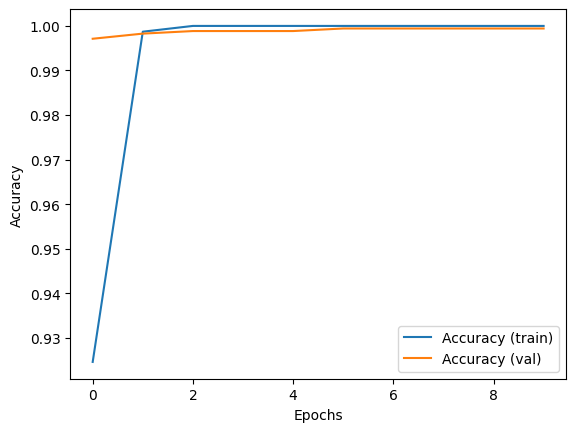

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['acc'], label='Accuracy (train)')
plt.plot(history.history['val_acc'], label='Accuracy (val)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

***Extraire les embeddings des images directement à partir du
modèle***

In [ ]:
from tensorflow.keras.preprocessing import image

def extract_embeddings_from_dataset(model, dataset):
    embeddings = []
    for images, _ in dataset:
        preprocessed_images = tf.keras.applications.inception_v3.preprocess_input(images.numpy())

        batch_embeddings = model.predict(preprocessed_images, batch_size=32, verbose=0)

        embeddings.extend(batch_embeddings)

    return np.array(embeddings)

embeddings = extract_embeddings_from_dataset(model, train_ds)
print("Embeddings shape:", embeddings.shape)

Embeddings shape: (6952, 49)


In [ ]:
!pip install plotly

In [35]:
import plotly.express as px
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd


def visualize_embeddings_tsne_plotly(embeddings, labels, class_names):
    if embeddings.ndim > 2:
        embeddings = embeddings.reshape(embeddings.shape[0], -1)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced_embeddings = tsne.fit_transform(embeddings)

    df = pd.DataFrame(reduced_embeddings, columns=['tsne_1', 'tsne_2'])
    df['label'] = labels
    df['class_name'] = df['label'].map(lambda x: class_names[x])

    fig = px.scatter(df, x='tsne_1', y='tsne_2', color='class_name',
                     hover_data=['class_name'],
                     title='t-SNE Embeddings Visualization with Plotly')

    fig.show()


labels = np.concatenate([y for x, y in train_ds], axis=0)

print("Embeddings shape before visualization:", embeddings.shape)
visualize_embeddings_tsne_plotly(embeddings, labels, class_names)

Embeddings shape before visualization: (6952, 49)


In [36]:
model.save('my_model_inceptionV3.keras')
np.save('inceptionv3_embeddings.npy', embeddings)


***Test it sur des images hors de la dataset***

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Prédictions : ['HANDBAGS']


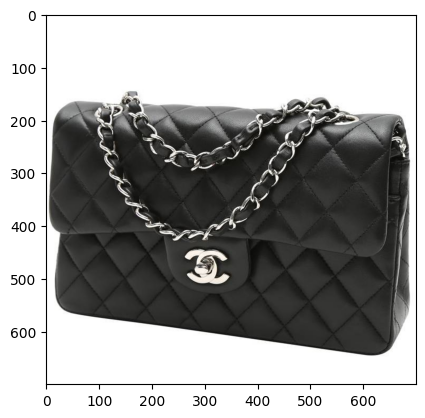

In [66]:
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

img_path = '/content/Test/1.jpg'
img_array = load_and_preprocess_image(img_path)
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
predicted_label = class_names[predicted_class]
print("Prédictions :", predicted_label)
img = Image.open(img_path)
plt.imshow(img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Prédictions : ['SUNGLASSES']


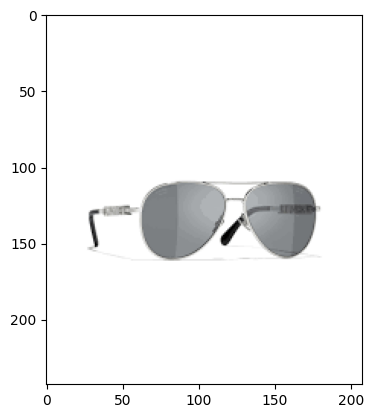

In [67]:

img_path = '/content/Test/2.png'
img_array = load_and_preprocess_image(img_path)
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
predicted_label = class_names[predicted_class]
print("Prédictions :", predicted_label)
img = Image.open(img_path)
plt.imshow(img)